# Problem description

In this project we are trying to classify dog breed from an image using a convolutional neural network. 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Input
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf

# Set train and test directories, and set 
train_dir = '/kaggle/input/dog-breed-identification/train'
test_dir = '/kaggle/input/dog-breed-identification/test'
sample_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')

2024-08-21 04:36:43.961402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 04:36:43.961505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 04:36:44.102612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
breeds_len = len(train_labels['breed'].unique())

print(train_labels.info())
print()
print(train_labels.head())
print()
print(train_labels['breed'].unique())
print(len(train_labels['breed'].unique()))
print()
print(sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 

There are 10,222 samples for the training data. There are 120 unique breeds that are going to be classified. The labels match up to a file in the train directory. The testing data has 10,357 samples.

# Exploratory Data Analysis

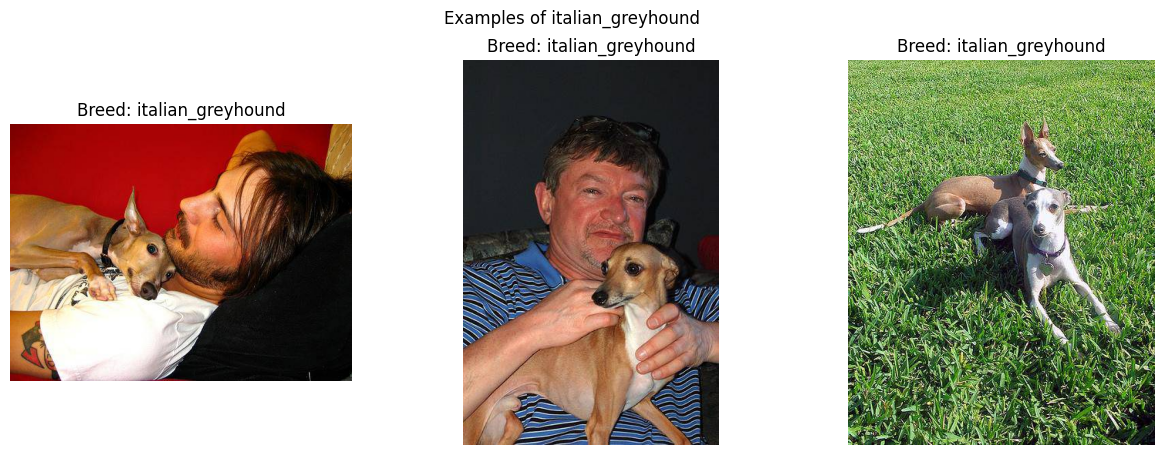

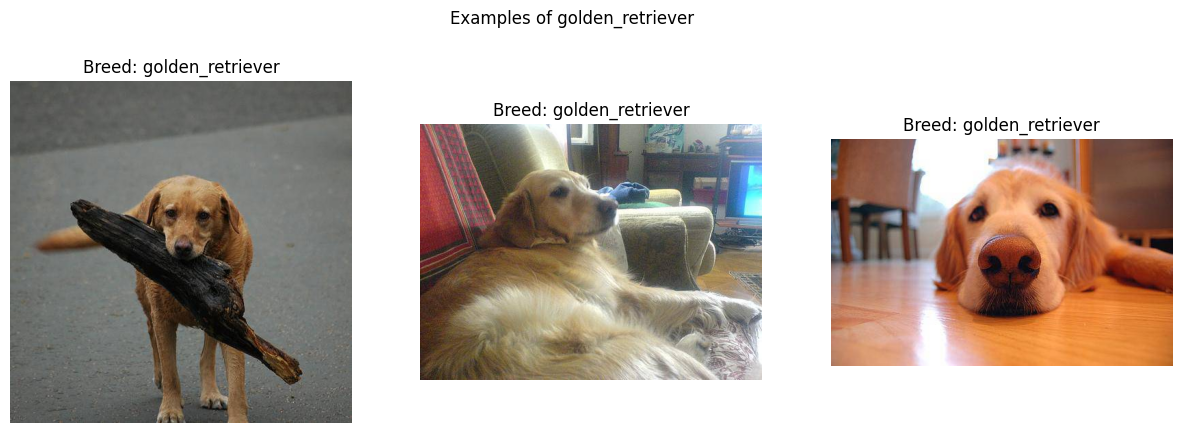

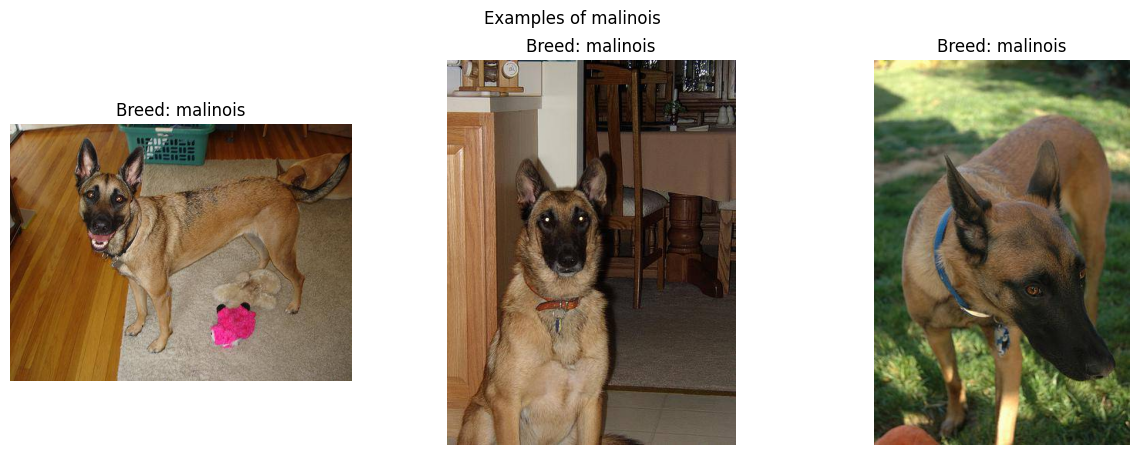

In [3]:
# Visualize some of the images
def show_images(ids, labels, path, title):
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(ids, labels)):
        img_path = os.path.join(path, img_id + '.jpg')
        img = Image.open(img_path)
        plt.subplot(1, len(ids), i+1)
        plt.imshow(img)
        plt.title(f"Breed: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def get_images_for_breed(df, breed_name, num_images=3):
    breed_images = df[df['breed'] == breed_name].head(num_images)
    return breed_images['id'], breed_images['breed']

def show_images_for_breed(df, breed_name, path, num_images=3):
    ids, breeds = get_images_for_breed(df, breed_name, num_images)
    show_images(ids, breeds, path, f"Examples of {breed_name}")

show_images_for_breed(train_labels, 'italian_greyhound', train_dir)
show_images_for_breed(train_labels, 'golden_retriever', train_dir)
show_images_for_breed(train_labels, 'malinois', train_dir)

The images are quite varied and can include other objects in the photos, dogs in different positions and angles, or obstructions in front of the dog. This will make it harder to train the model, but hopefully better at generalizing to the test photos.

In [4]:
# Print the length of the train and test dirs
num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
total_len_of_dataset = num_train_images + num_test_images
print(f"Number of training images: " + str(round(num_train_images / total_len_of_dataset, 2)))
print(f"Number of test images: " + str(round(num_test_images / total_len_of_dataset, 2)))

Number of training images: 0.5
Number of test images: 0.5


The training and testing datasets are near even in terms of length, with the testing dataset having slightly more samples.

Unique image dimensions in the training dataset:
       Width  Height
0        500     375
3        400     344
4        500     500
6        500     470
7        231     227
...      ...     ...
10202    492     543
10207    300     479
10210    914    1216
10213    337     383
10217    450     556

[2656 rows x 2 columns]


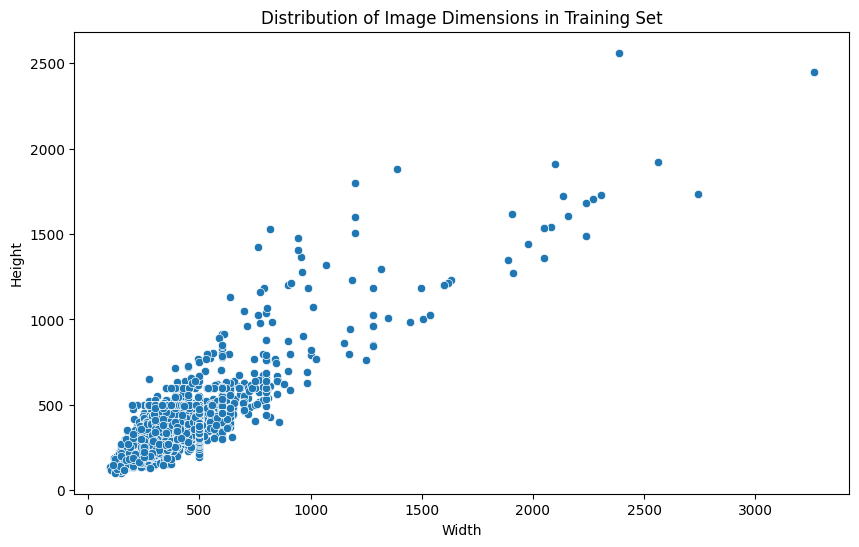

In [5]:
def check_image_dimensions(image_ids, image_dir):
    dimensions = []
    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id + '.jpg')
        with Image.open(img_path) as img:
            dimensions.append(img.size)
    return dimensions

# Get the dimensions of all images in the training set
image_dimensions = check_image_dimensions(train_labels['id'], train_dir)

dimensions_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

unique_dimensions = dimensions_df.drop_duplicates()

print("Unique image dimensions in the training dataset:")
print(unique_dimensions)

# Visualize the distribution of image dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Width', y='Height', data=dimensions_df)
plt.title('Distribution of Image Dimensions in Training Set')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

So this is not great - the images have vastly different dimensions. Prior to training I will need to transform these images into the same dimensions.

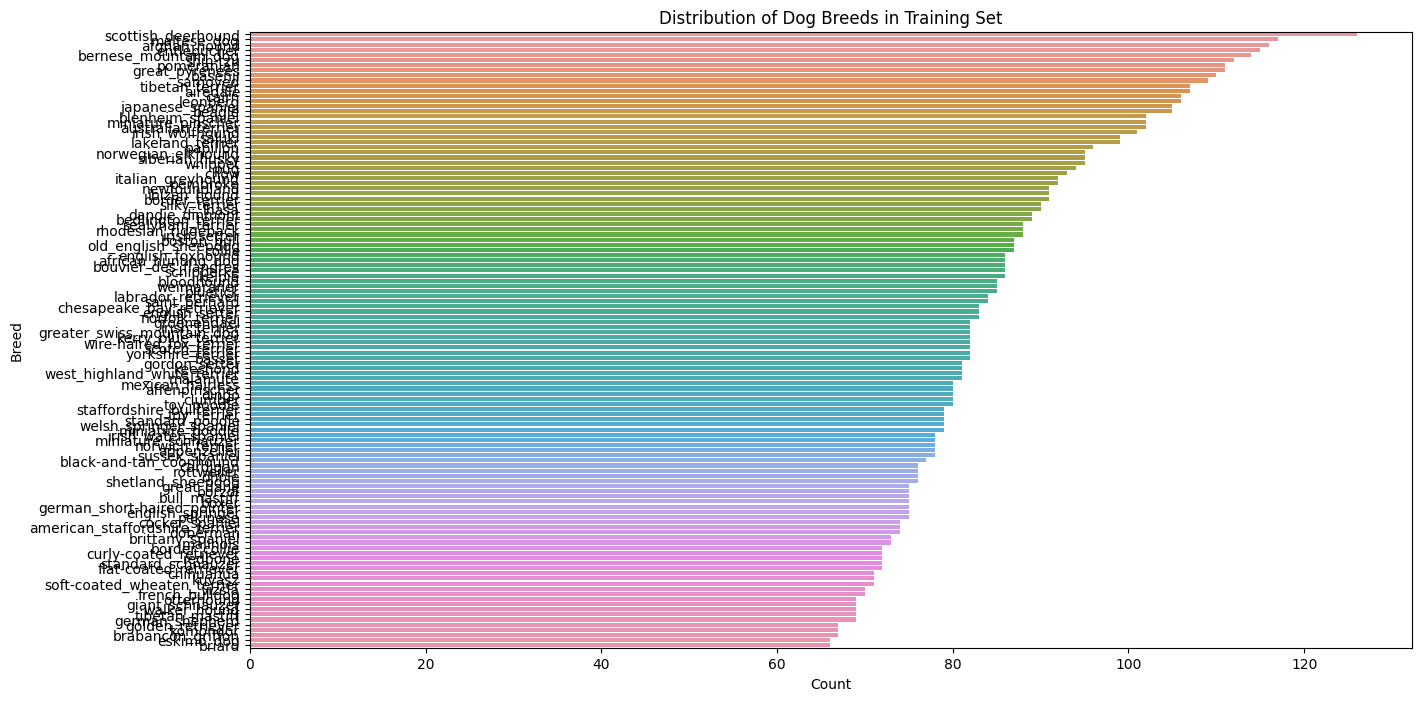

In [6]:
# Print the distribution of breeds in the training set
plt.figure(figsize=(15, 8))
sns.countplot(y='breed', data=train_labels, order=train_labels['breed'].value_counts().index)
plt.title('Distribution of Dog Breeds in Training Set')
plt.xlabel('Count')
plt.ylabel('Breed')
plt.show()

The pictures are not evenly distributed in terms of breed, as the difference between the most and least frequent is almost a 2x difference.

## Image Preprocessing

So there's not too much I can do about the uneven nature of the dog breed images, but it is going to be necessary to standardize the images prior to training. Below I will be doing the following:
* Scaling the images to 224x224. Given the amount of images in this project, I am sacrificing the performance of the models for a reasonable training time.
* Normalize the color values from 0-255 to 0-1

I am also adding in variance to help improve the flexibility of the models by maninpulation the images thorugh rotating, shifting, shearing, zooming, flipping, and brightness. 

I use flow_from_dataframe to produce training and validation data sets in a 80-20 split.

In [7]:
# Image preprocessing
target_size = (224, 224)
batch_size = 16

# The file id's must have the .jpg extension added to work with the flow_from_dataframe function
train_labels['image_path'] = train_labels['id'].apply(lambda x: x + '.jpg')

train_df, val_df = train_test_split(train_labels, test_size=0.20, stratify=train_labels['breed'], random_state=13)

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])
val_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])

train_data_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                         directory=train_dir,
                                                         x_col='image_path',
                                                         y_col='breed',
                                                         target_size=target_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=True)

validation_data_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                            directory=train_dir,
                                                            x_col='image_path',
                                                            y_col='breed',
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            shuffle=True)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


# Model Architecture

Three models will be tested and compared. 

The first model will have the architecture of:

Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
* Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
* MaxPooling2D(2, 2),

Second convolutional layer with 32 filters
* Conv2D(32, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Third convolutional layer with 64 filters
* Conv2D(64, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

* Flatten(),

Dense layer with dropout for regularization
* Dense(256, activation='relu'),
* Dropout(0.15),

Output layer that uses softmax to predict all of the probabilities that the picture contains a particular breed
* Dense(num of breeds, activation='softmax')

The second model will have the architecture of:

* Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), kernel_regularizer=l2(.0015)),
* Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
* BatchNormalization(),
* MaxPooling2D(2, 2),

* Flatten(),

* Dense(256, activation='relu', kernel_regularizer=l2(.0015)),
* Dropout(0.4),
* Dense(num of breeds, activation='softmax')

Third model architecture:

Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
* Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
* Conv2D(16, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Second convolutional layer with 32 filters
* Conv2D(32, (3, 3), activation='relu'),
* Conv2D(32, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

Third convolutional layer with 64 filters
* Conv2D(64, (3, 3), activation='relu'),
* Conv2D(64, (3, 3), activation='relu'),
* MaxPooling2D(2, 2),

* Flatten(),

Dense layer with dropout for regularization
* Dense(256, activation='relu'),
* Dropout(0.25),

Output layer that uses softmax to predict all of the probabilities that the picture contains a particular breed
* Dense(num of breeds, activation='softmax')


For the final model, I brought in the external ResNet50V2 model to try and improve on my scores. It is a CNN with 50 layers that has been trained on a large corpus of images (more than just dogs), but would perform better than any CNN I'd be able to make here. By having it as the base model I can add a couple of layers beneath it to classify the dog breeds by leveraging ResNet50V2. 

After ResNet50V2, I have the following structure:

* Dense(512, activation='relu')
* Dropout(.5)
* Dense(256, activation='relu')
* Dropout(.3)
* Dense(num of breeds, activation='softmax')


The first model is quite simple with single convolutional layers that increasingly increase in filter size. The dense layer has a small dropout afterwards to help with overfitting, but it's not much since the model is simple. 

The second model is a much more powerful (on paper) model that has convolutional layers back to back with double the filter sizes as the first model. It also has l2 regularization and more dropouts. The idea is since this is so complex, it needs more regularization to help prevent overfitting. 

The third model is a mix of the first and second modal, with 2 convolution layers back to back before pooling, and a slightly increased dropout.

The fourth model is truly the most powerful model that leverages ResNet50V2 as a base model with some dense layers beneath it.

All models have early stopping enabled if the model doesn't improve. The second model also implements learning rate reduction when the validation loss plateaus.

# Results and Analysis

In [8]:
# First model architecture
model = Sequential([
    # Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2, 2),
    # Second convolutional layer with 32 filters
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    # Dense layer with dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.15),
    # Output layer with a single neuron and sigmoid activation function for binary classification
    Dense(breeds_len, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    11,075,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,130,264 (42.46 MB)

 Trainable params: 11,130,264 (42.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-21 04:38:35.714327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49293: 7.29743, expected 6.46071
2024-08-21 04:38:35.714390: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49294: 7.12612, expected 6.2894
2024-08-21 04:38:35.714400: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 5.65411, expected 4.81739
2024-08-21 04:38:35.714408: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 6.79266, expected 5.95594
2024-08-21 04:38:35.714417: E external/local_xla/xla/service/gpu/buffer_c

  1/511 ━━━━━━━━━━━━━━━━━━━━ 1:42:37 12s/step - accuracy: 0.0000e+00 - auc: 0.5864 - loss: 4.7617

I0000 00:00:1724215122.363244     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724215122.386678     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/511 ━━━━━━━━━━━━━━━━━━━━ 1:15 225ms/step - accuracy: 0.0118 - auc: 0.5036 - loss: 5.2874

2024-08-21 04:39:22.766042: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98572: 6.93899, expected 6.00904
2024-08-21 04:39:22.766110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98573: 7.77716, expected 6.8472
2024-08-21 04:39:22.766125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98574: 7.66697, expected 6.73702
2024-08-21 04:39:22.766136: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98575: 7.14765, expected 6.2177
2024-08-21 04:39:22.766144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98576: 7.57232, expected 6.64237
2024-08-21 04:39:22.766153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98577: 6.63563, expected 5.70568
2024-08-21 04:39:22.766161: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98578: 7.52746, expected 6.59751
2024-08-21 04:39:22.766169: E

510/511 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.0104 - auc: 0.5028 - loss: 5.0144

W0000 00:00:1724215241.696376     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


511/511 ━━━━━━━━━━━━━━━━━━━━ 159s 287ms/step - accuracy: 0.0104 - auc: 0.5028 - loss: 5.0137 - val_accuracy: 0.0113 - val_auc: 0.5000 - val_loss: 4.7840
Epoch 2/20
  1/511 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0000e+00 - auc: 0.5000 - loss: 4.7876

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-21 04:41:09.126185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 107016: 5.75003, expected 5.06946
2024-08-21 04:41:09.126330: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 116995: 5.75003, expected 5.06946
2024-08-21 04:41:09.126437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 126976: 5.75003, expected 5.06946
2024-08-21 04:41:09.126527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 136955: 5.75003, expected 5.06946
2024-08-21 04:41:09.126617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 146934: 5.750

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - auc: 0.5000 - loss: 4.7876 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 4.7915
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 138s 267ms/step - accuracy: 0.0108 - auc: 0.5001 - loss: 4.7841 - val_accuracy: 0.0123 - val_auc: 0.5000 - val_loss: 4.7813
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.0000e+00 - auc: 0.5000 - loss: 4.7935 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 4.7885
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 141s 273ms/step - accuracy: 0.0135 - auc: 0.5000 - loss: 4.7817 - val_accuracy: 0.0123 - val_auc: 0.5002 - val_loss: 4.7794
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.0000e+00 - auc: 0.5000 - loss: 4.7931 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_loss: 4.7858
Epoch 7/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 141s 272ms/step - accuracy: 0.0145 - auc: 0.5013 - loss: 4.7786 - val_accuracy: 0.0123 - val_auc: 0.5019 - val_loss: 4.7782
Epoch 8/20


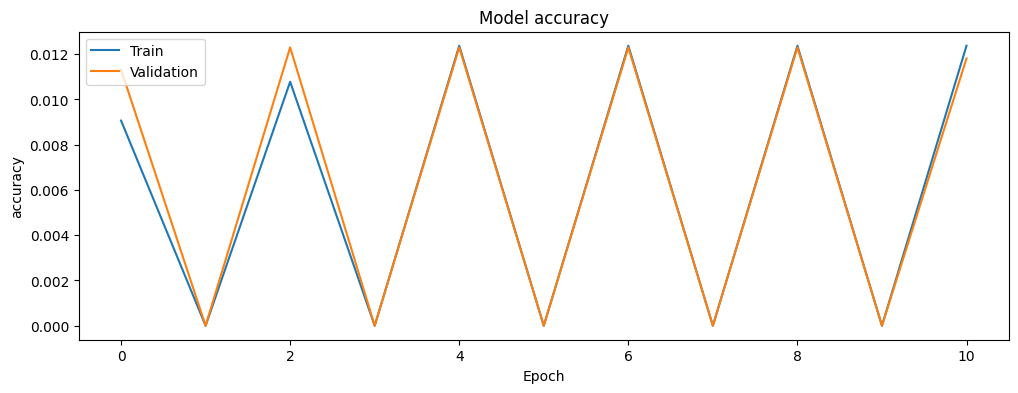

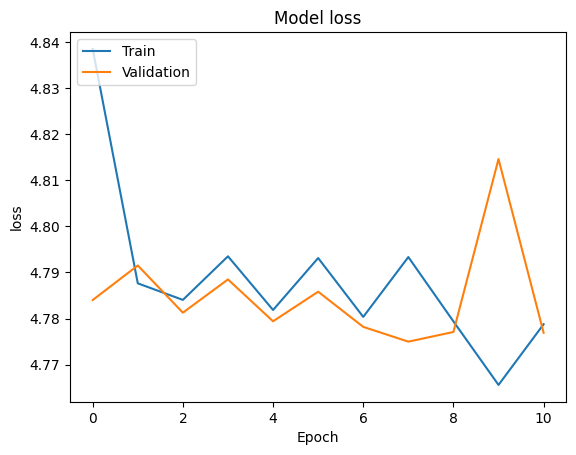

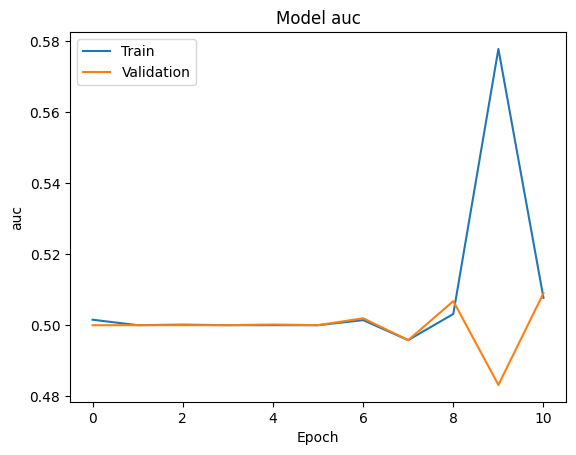

In [9]:
def plot_metric(history, metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'auc')

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Second model architecture
second_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3), kernel_regularizer=l2(.0015)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(.0015)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(.0015)),
    Dropout(0.4),
    Dense(breeds_len, activation='softmax')
])

second_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

second_model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

# Training the model
history = second_model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,193,368 (73.22 MB)

 Trainable params: 19,192,920 (73.22 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


2024-08-21 04:52:51.803437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148273: 4.10347, expected 3.58648
2024-08-21 04:52:51.803501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149075: 3.91455, expected 3.39756
2024-08-21 04:52:51.803517: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149093: 3.88055, expected 3.36356
2024-08-21 04:52:51.803529: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 4.10975, expected 3.59276
2024-08-21 04:52:51.803543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149850: 3.98709, expected 3.4701
2024-08-21 04:52:51.803569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 151973: 3.89678, expected 3.37979
2024-08-21 04:52:51.803587: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 153061: 4.10204, expected 3.58504
2024-08-21 04:52:51.8

251/511 ━━━━━━━━━━━━━━━━━━━━ 54s 211ms/step - accuracy: 0.0106 - auc: 0.5057 - loss: 12.9444

2024-08-21 04:53:56.269988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.14435, expected 3.59734
2024-08-21 04:53:56.270055: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148032: 3.73171, expected 3.1847
2024-08-21 04:53:56.270071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148049: 4.2981, expected 3.75109
2024-08-21 04:53:56.270101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 4.2275, expected 3.68049
2024-08-21 04:53:56.270115: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 3.89754, expected 3.35053
2024-08-21 04:53:56.270127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149444: 4.35104, expected 3.80403
2024-08-21 04:53:56.270138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149482: 4.25819, expected 3.71118
2024-08-21 04:53:56.270

511/511 ━━━━━━━━━━━━━━━━━━━━ 157s 275ms/step - accuracy: 0.0109 - auc: 0.5038 - loss: 10.5801 - val_accuracy: 0.0074 - val_auc: 0.5026 - val_loss: 6.4939 - learning_rate: 0.0010
Epoch 2/20
  1/511 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.0000e+00 - auc: 0.5235 - loss: 6.3499

2024-08-21 04:55:22.775606: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.85897, expected 6.06893
2024-08-21 04:55:22.775660: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.96167, expected 5.17163
2024-08-21 04:55:22.775670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.44264, expected 5.65259
2024-08-21 04:55:22.775678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23199, expected 5.44195
2024-08-21 04:55:22.775686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.01164, expected 4.22159
2024-08-21 04:55:22.775694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.90012, expected 5.11007
2024-08-21 04:55:22.775701: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 6.65641, expected 5.86637
2024-08-21 04:55:22.775709: E external/local_xla/xl

511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0000e+00 - auc: 0.5235 - loss: 6.3499 - val_accuracy: 0.0769 - val_auc: 0.5000 - val_loss: 6.3802 - learning_rate: 0.0010
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 135s 262ms/step - accuracy: 0.0094 - auc: 0.4998 - loss: 6.1612 - val_accuracy: 0.0103 - val_auc: 0.4996 - val_loss: 5.5985 - learning_rate: 0.0010


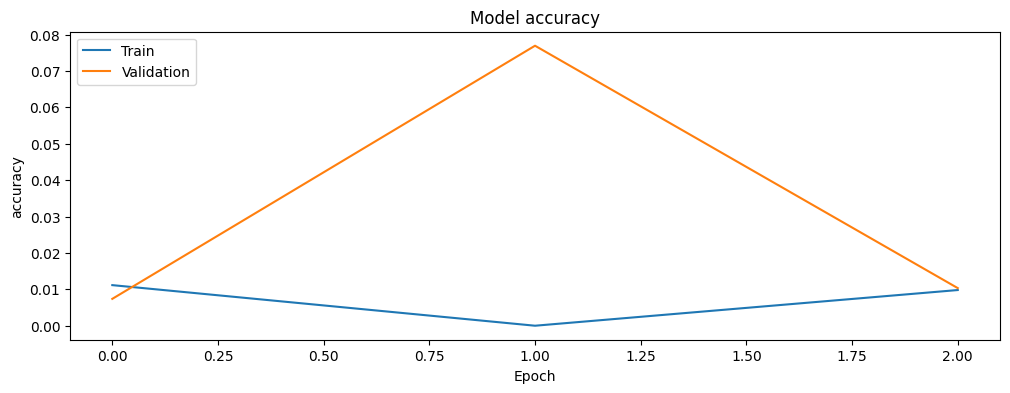

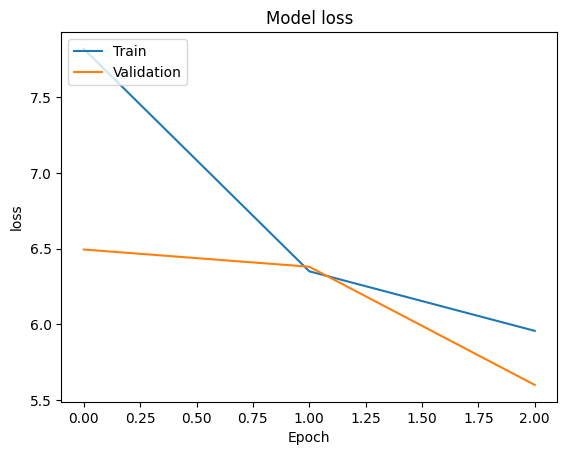

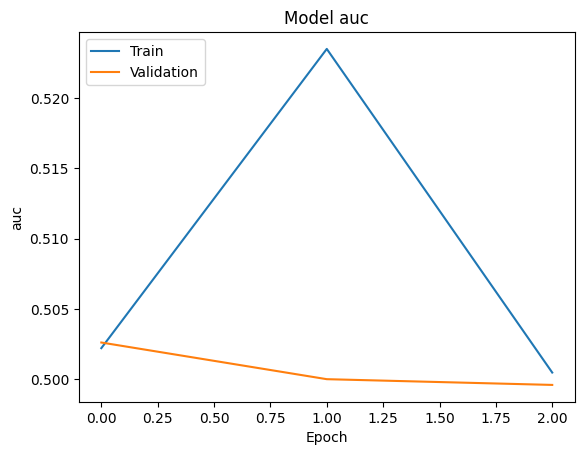

In [11]:
plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'auc')

In [12]:
# Third model architecture
third_model = Sequential([
    # Convolutional layer with 16 filters, kernel size of 3x3, activation function ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Second convolutional layer with 32 filters
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    # Dense layer with dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.25),
    # Output layer with a single neuron and sigmoid activation function for binary classification
    Dense(breeds_len, activation='softmax')
])

third_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

third_model.summary()

steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

# Training the model
history = third_model.fit(train_data_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=validation_data_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 220, 220, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,540,360 (36.39 MB)

 Trainable params: 9,540,360 (36.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 149s 273ms/step - accuracy: 0.0098 - auc: 0.5020 - loss: 4.9417 - val_accuracy: 0.0118 - val_auc: 0.4998 - val_loss: 4.7854
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0625 - auc: 0.5000 - loss: 4.7902 - val_accuracy: 0.0769 - val_auc: 0.5000 - val_loss: 4.7935
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - accuracy: 0.0116 - auc: 0.5005 - loss: 4.8559 - val_accuracy: 0.0123 - val_auc: 0.5000 - val_loss: 4.7813


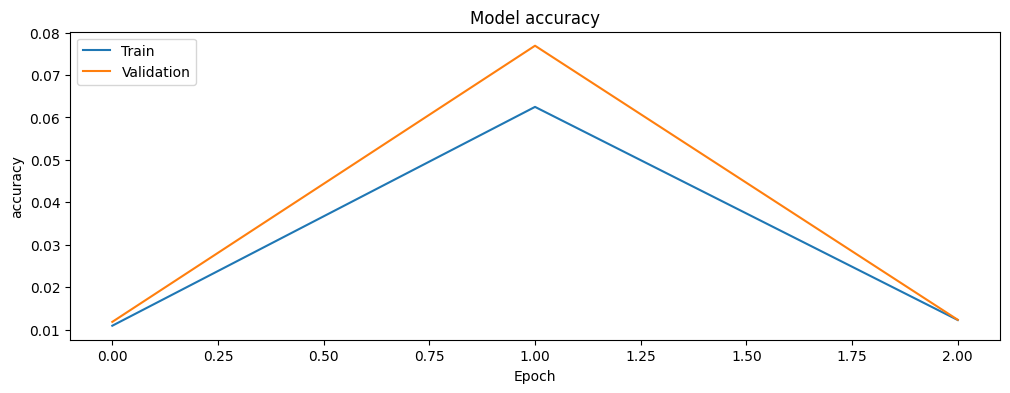

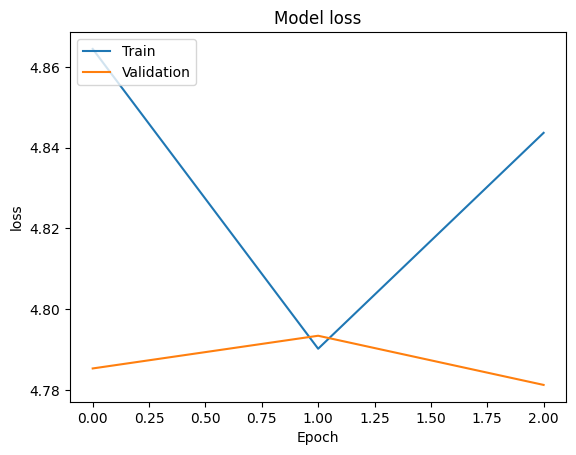

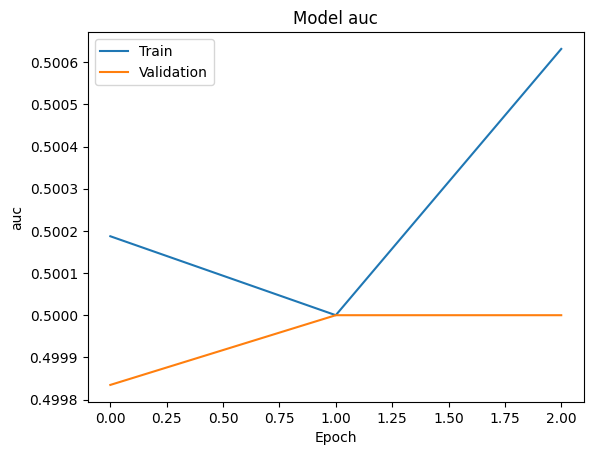

In [13]:
plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'auc')

In [14]:
input_shape = (224, 224, 3)

# Create the base model from the pre-trained ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers
custom_model = base_model.output
custom_model = GlobalAveragePooling2D()(custom_model)
custom_model = Dense(512, activation='relu')(custom_model)
custom_model = Dropout(0.5)(custom_model)
custom_model = Dense(256, activation='relu')(custom_model)
custom_model = Dropout(0.3)(custom_model)
outputs = Dense(breeds_len, activation='softmax')(custom_model)

# Assemble the full model
resnet_fancy_model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
resnet_fancy_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Steps
steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size
validation_steps = validation_data_generator.samples // validation_data_generator.batch_size

# Train the model
history = resnet_fancy_model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_data_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 172s 300ms/step - accuracy: 0.0527 - auc: 0.6505 - loss: 4.6516 - val_accuracy: 0.2667 - val_auc: 0.9143 - val_loss: 3.0915 - learning_rate: 0.0010
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0625 - auc: 0.9037 - loss: 3.4627 - val_accuracy: 0.0000e+00 - val_auc: 0.9170 - val_loss: 3.1779 - learning_rate: 0.0010
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 141s 273ms/step - accuracy: 0.1868 - auc: 0.8697 - loss: 3.3981 - val_accuracy: 0.3204 - val_auc: 0.9350 - val_loss: 2.7133 - learning_rate: 0.0010
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - accuracy: 0.3750 - auc: 0.9007 - loss: 2.9612 - val_accuracy: 0.3846 - val_auc: 0.9436 - val_loss: 3.0099 - learning_rate: 0.0010
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 141s 273ms/step - accuracy: 0.2358 - auc: 0.8973 - loss: 3.1043 - val_accuracy: 0.3735 - val_auc: 0.9466 - val_loss: 2.5416 - learning_rate: 0.0010
Epoch 6/50

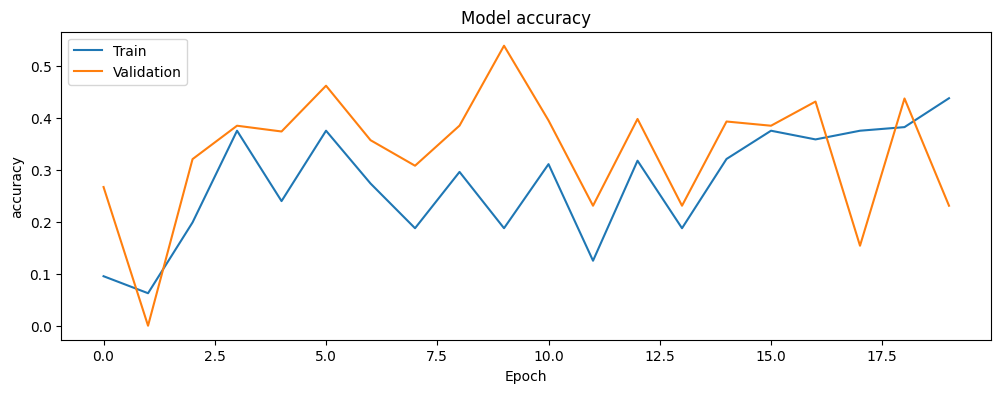

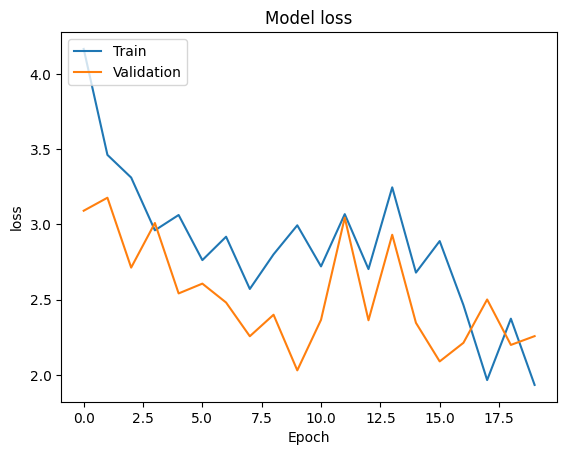

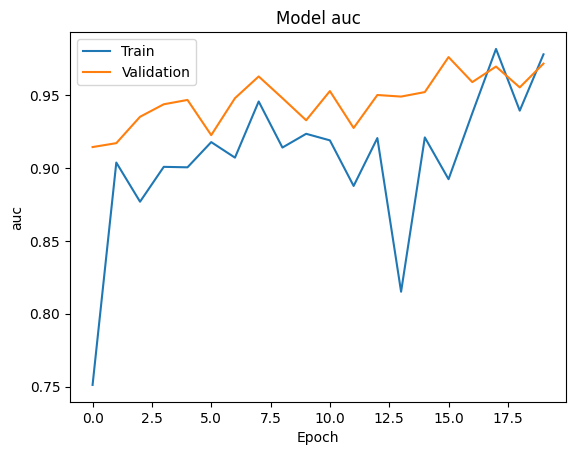

In [15]:
plt.figure(figsize=(12, 4))

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')
plot_metric(history, 'auc')

## Model Results

*These may not match exactly, but should hold true in general*

### Model 1 Results
Model 1 finished training with the following metrics:
accuracy: 0.0120 - auc: 0.5072 - loss: 4.7796 - val_accuracy: 0.0118 - val_auc: 0.5090 - val_loss: 4.7769

The training data resulted in a loss of 4.77, an accuracy of .01%, and auc of 50%. The validation data (20% of the dataset) has a loss of 4.7796, an accuracy of .01%, and an auc of .50%. These are quite poor results and the metrics are close for both the training and validation data. Looking at the graphs of the metrics, the results have a very jagged edge with the training and validation data typically matching up in the same score. In short, the model is too small to effectively learn.

### Model 2 Results
Model 2 finished training with the following metrics:
accuracy: 0.0094 - auc: 0.4998 - loss: 6.1612 - val_accuracy: 0.0103 - val_auc: 0.4996 - val_loss: 5.5985 - learning_rate: 0.0010

The metrics are worse across the board compared to the first model in both training and validation data, so even though the model was more powerful it didn't matter.

### Model 3 Results
Model 3 finished training with the following metrics:
accuracy: 0.0116 - auc: 0.5005 - loss: 4.8559 - val_accuracy: 0.0123 - val_auc: 0.5000 - val_loss: 4.7813

The metrics match up close to the first model, albeit still worse. These small models really struggle to learn the dog breeds.

### Model 4 Results
Model 4 finished training with the following metrics:
accuracy: 0.4375 - auc: 0.9778 - loss: 1.9333 - val_accuracy: 0.2308 - val_auc: 0.9715 - val_loss: 2.2577 - learning_rate: 2.0000e-04

Model 4 is clearly the best model by a long shot, with a loss of 1.933 and 43.75% accuracy for the training data, and validation having a loss of 2.2577 and accuracy of 23%. Whilst not amazing, it's better than the rest. The AUC for both training and validation is 97%+ which is good.

## Submission Results

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_files = os.listdir(test_dir)
test_dataframe = pd.DataFrame(test_files, columns=['image_path'])
test_data_generator = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                                    directory=test_dir,
                                                    x_col='image_path',
                                                    y_col=None,
                                                    target_size=target_size,
                                                    class_mode=None,
                                                    workers=4,
                                                    use_multiprocessing=True)

Found 10357 validated image filenames.


In [17]:
predictions = resnet_fancy_model.predict(test_data_generator)

# Number of predictions
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_data_generator.filenames)}")

# Create the submission dataframe
submission_dataframe = pd.DataFrame(predictions, columns=train_data_generator.class_indices.keys())
submission_dataframe['id'] = test_data_generator.filenames
submission_dataframe['id'] = submission_dataframe['id'].apply(lambda x: x.split('.')[0]) # remove .jpg from the id

cols = submission_dataframe.columns.tolist()
cols = cols[-1:] + cols[:-1]
submission_dataframe = submission_dataframe[cols]

# Save the submission dataframe to a CSV file
submission_dataframe.to_csv('submission.csv', index=False)

324/324 ━━━━━━━━━━━━━━━━━━━━ 109s 312ms/step
Number of predictions: 10357
Number of test samples: 10357


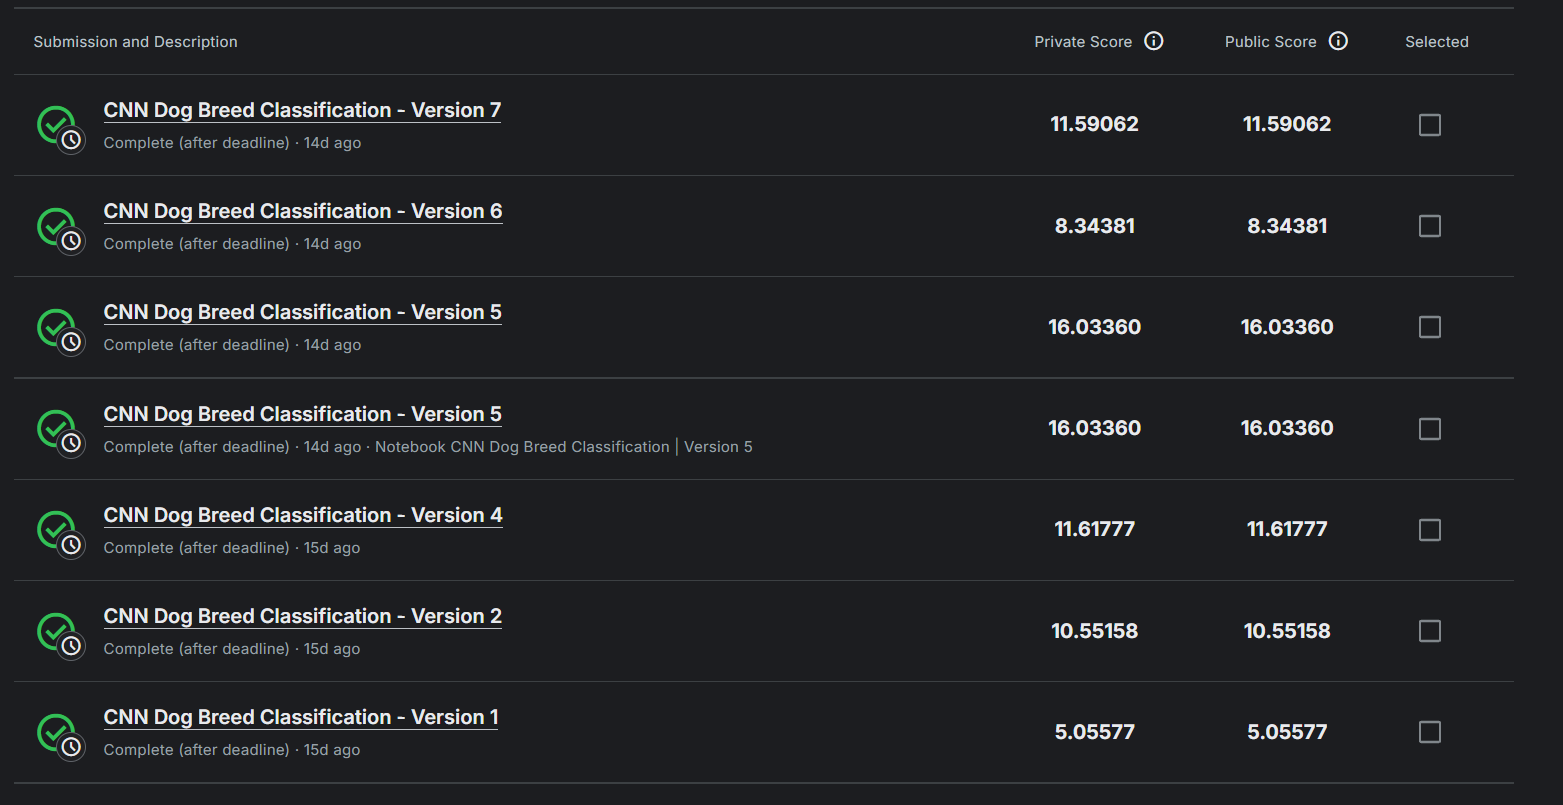

The first submission was with the first model and most of the subsequent tests were with the ResNet enhanced model. For some reason, even though the enhanced model had drastically better results in training, I could never get the score to be better than the first model with no extra variations to the image.

# Conclusion

While the ResNet model got better results in training, it still never beat the first model submission score. It's possible it was a lucky submission and to not put much stock in it. Either way, it's frustrating not to be able to get a higher score.

For future work, I think trying other pre-trained models would be helpful, along with allowing some of the layers of some of these pre-trained models to be trained. This could potentially improve the score. All in all though, I'm happy with learning some new ways to modify the training data and using pre-trained models to achieve better results.